In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import sys
sys.path.append("../../../../../src/")
import nanonets_utils
import nanonets
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
plt.style.use(["science","bright","grid"])

cm  = plt.get_cmap('cividis')
ma  = ["o","s","^","v","<",">"]

In [2]:
def mutal_capacitance_adjacent_spheres(eps_r: float, np_radius1: float, np_radius2: float, np_distance: float)->float:

    d       = (np_radius1 + np_radius2 + np_distance)
    factor  = 4*3.14159265359*8.85418781762039*0.001*eps_r*(np_radius1*np_radius2)/d
    # Paper approx sum_val = 1
    sum_val = sum([1,(np_radius1*np_radius2)/(d**2-2*np_radius1*np_radius2),
                    ((np_radius1**2)*(np_radius2**2))/(d**4-4*(d**2)*np_radius1*np_radius2+3*(np_radius1**2)*(np_radius2**2))])
    cap     = factor*sum_val

    return np.round(cap,2)*1e-18

def self_capacitance_sphere(eps_s: float, np_radius: float)->float:

    factor  = 4*3.14159265359*8.85418781762039*0.001*eps_s
    cap     = factor*np_radius

    return np.round(cap,2)*1e-18

R   = 25*1e6
Cm  = mutal_capacitance_adjacent_spheres(2.6, 10, 10, 1)
Cs  = self_capacitance_sphere(3.9, 10)

## DC Input - Voltage Distribution - Closed Circuit

In [3]:
folder1     = "/home/j/j_mens07/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_volt/"
folder2     = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_volt/"
U0_vals     = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
N_p         = 50

N_voltages      = 40000
t_vals_closed   = np.arange(N_voltages-1)*1e-10*1e9
pot_closed      = {U_0 : pd.read_csv(f"{folder1}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2_{U_0}.csv").round(5) for U_0 in U0_vals}
pot_eq_closed   = pd.DataFrame([pot_closed[U_0].iloc[38000:,:].mean().values / U_0 for U_0 in U0_vals],index=U0_vals).T.round(2)

N_voltages      = 50000
t_vals_open     = np.arange(N_voltages-1)*1e-10*1e9
pot_open        = {U_0 : pd.read_csv(f"{folder2}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2_{U_0}.csv").round(5) for U_0 in U0_vals}
pot_eq_open     = pd.DataFrame([pot_open[U_0].iloc[48000:,:].mean().values / U_0 for U_0 in U0_vals],index=U0_vals).T.round(2)

### Steady State

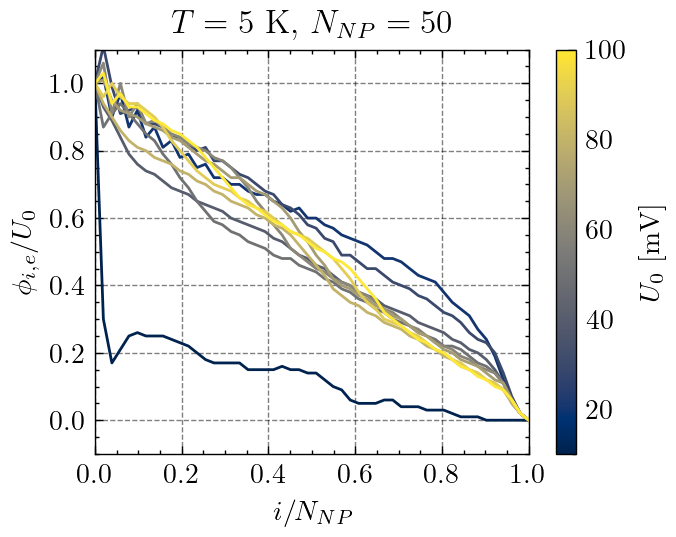

In [5]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(U0_vals)*1000, vmax=max(U0_vals)*1000)

for i, U_0 in enumerate(U0_vals):

    p   = pot_eq_closed[U_0].dropna().values.copy()
    p   = np.insert(p, 0, 1.0)
    p   = np.append(p, 0.0)
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(U_0*1000)))

ax.set_title("$T = 5$ K, $N_{NP} = 50$")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_0$ [mV]")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_potential_vs_volt.svg", transparent=True)

Text(0.5, 12.31756469338072, '$i$')

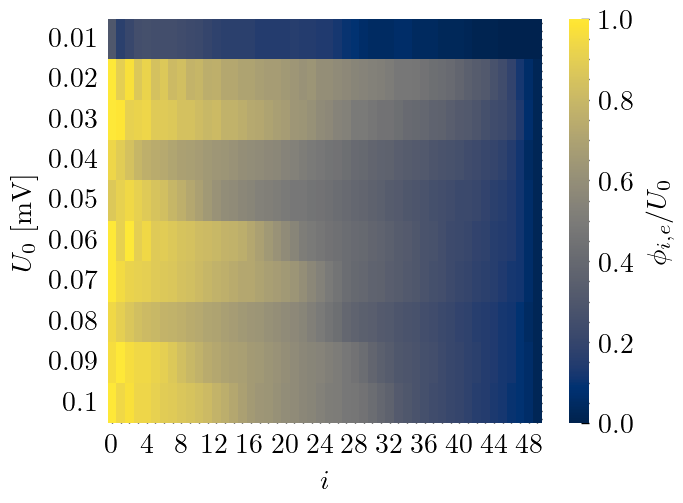

In [21]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(pot_eq_closed.T, cmap='cividis', vmin=0, vmax=1, cbar_kws={"label":"$\phi_{i,e} / U_0$"})
ax.set_ylabel("$U_0$ [mV]")
ax.set_xlabel("$i$")

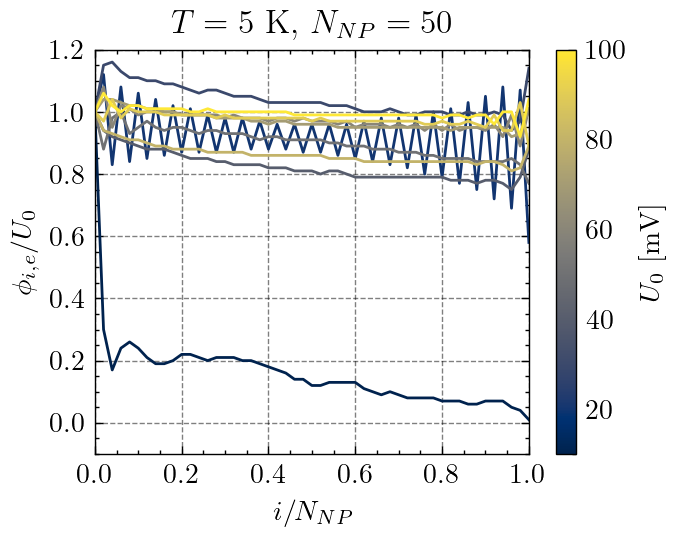

In [22]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(U0_vals)*1000, vmax=max(U0_vals)*1000)

for i, U_0 in enumerate(U0_vals):

    p   = pot_eq_open[U_0].dropna().values.copy()
    p   = np.insert(p, 0, 1.0)
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(U_0*1000)))

ax.set_title("$T = 5$ K, $N_{NP} = 50$")
ax.set_ylim(-0.1,1.2)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_0$ [mV]")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_potential_difference_vs_volt.svg", transparent=True)

### Characteristic Time Scale

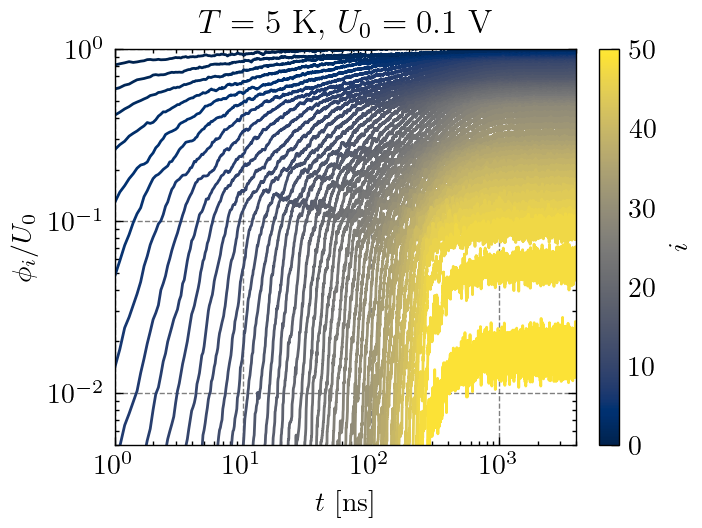

In [23]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
norm    = Normalize(vmin=0, vmax=50)
Np      = 50
U_0     = 0.1

for i in range(Np):
    ax.plot(t_vals_closed, pot_closed[U_0][f"{i}"].values/U_0, color=cm(norm(i)))

ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
ax.set_xlim(1,4000)
ax.set_ylim(0.005,1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

# fig.savefig("../plots/dc_input/linear/closed_circuit_node_time_series.svg", transparent=True)

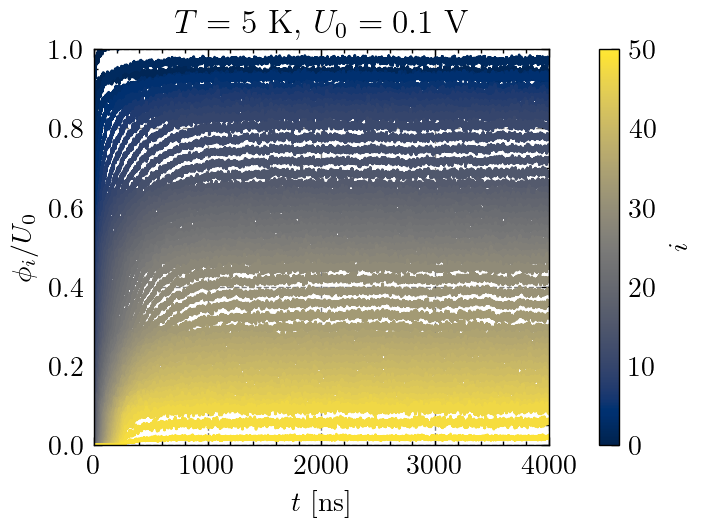

In [24]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
norm    = Normalize(vmin=0, vmax=50)
Np      = 50
U_0     = 0.1

for i in range(Np):
    ax.plot(t_vals_closed, pot_closed[U_0][f"{i}"].values/U_0, color=cm(norm(i)))

ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
ax.set_xlim(0,4000)
ax.set_ylim(0,1)
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

# fig.savefig("../plots/dc_input/linear/closed_circuit_node_time_series.svg", transparent=True)

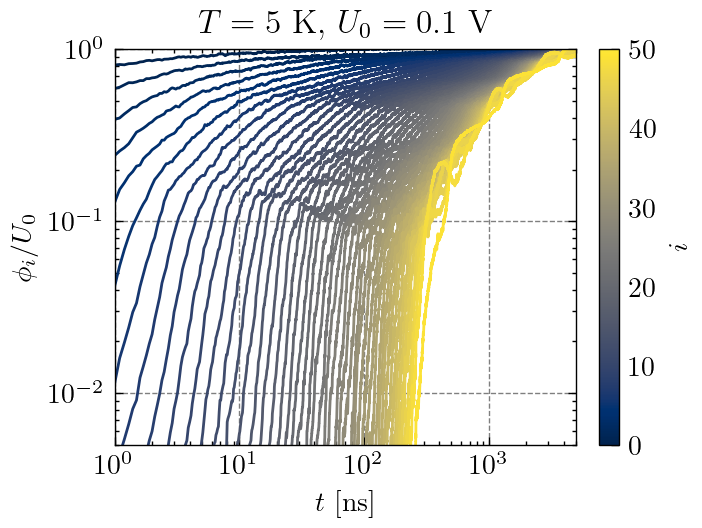

In [25]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
norm    = Normalize(vmin=0, vmax=50)
Np      = 50
U_0     = 0.1

for i in range(Np):
    ax.plot(t_vals_open, pot_open[U_0][f"{i}"].values/U_0, color=cm(norm(i)))

ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
ax.set_xlim(1,5000)
ax.set_ylim(0.005,1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

# fig.savefig("../plots/dc_input/linear/closed_circuit_node_time_series.svg", transparent=True)

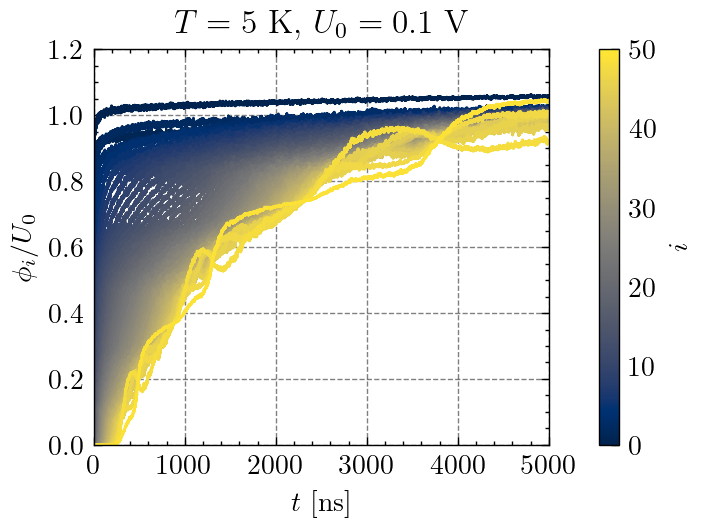

In [84]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
norm    = Normalize(vmin=0, vmax=50)
Np      = 50
U_0     = 0.1

for i in range(Np):
    ax.plot(t_vals_open, pot_open[U_0][f"{i}"].values/U_0, color=cm(norm(i)))

ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
ax.set_xlim(0,5000)
ax.set_ylim(0,1.2)
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

# fig.savefig("../plots/dc_input/linear/closed_circuit_node_time_series.svg", transparent=True)

Text(42.06756469338072, 0.5, '$k$')

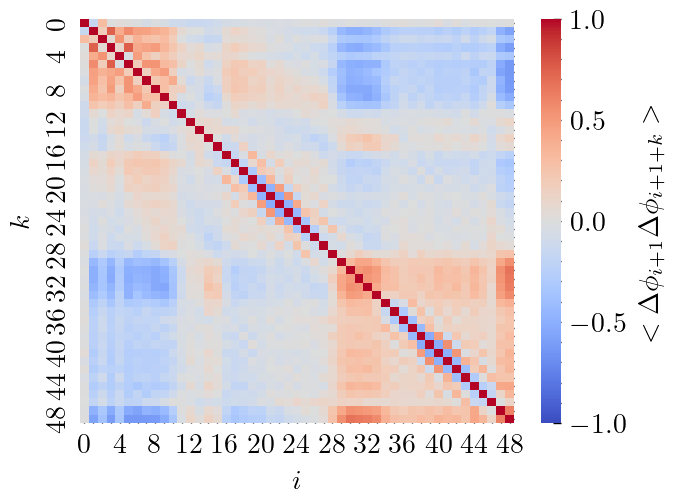

In [98]:
U_0     = 0.1
p_diff  = pot_closed[U_0].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax, cbar_kws={"label":"$<\Delta\phi_{i+1}\Delta\phi_{i+1+k}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")

Text(42.06756469338072, 0.5, '$k$')

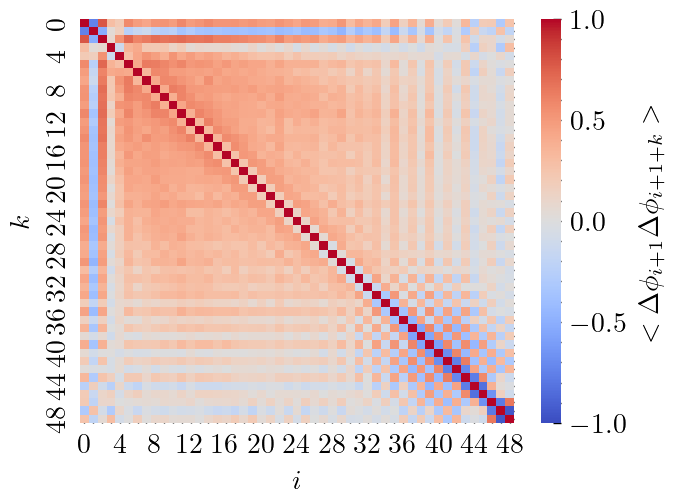

In [101]:
U_0     = 0.1
p_diff  = pot_open[U_0].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax, cbar_kws={"label":"$<\Delta\phi_{i+1}\Delta\phi_{i+1+k}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")

- Strong short range correlations: Diffusive charge spreading
- Long range anti-correlations: Charges at distant NPs adjust to maintain linear potential gradient globally

In [8]:
def characteristic_time(t_vals, pot_df, Np, steady_start=20000, consecutive_points=50, p_th=0.63):

    end_vals    = pot_df[Np].iloc[steady_start:,:].mean().values
    taus        = []
    p_th        = 0.63

    for i in range(Np):
        vals        = pot_df[Np].loc[:,f'{i}'].values
        threshold   = p_th*end_vals[i]
        above_th    = vals > threshold
        for j in range(len(above_th) - consecutive_points):
            if all(above_th[j:j+consecutive_points]):
                tau = t_vals[j]
                taus.append(tau)
                break
    
    return taus

def characteristic_time_saturation(t_vals, pot_df, Np):

    def saturation_cuve(t, tau, a0):
        return a0*(1 - np.exp(-(t) / tau))

    tau = []
    std = []
    for i in range(Np):
        x       = t_vals.copy()
        y       = pot_df[Np].loc[:,f'{i}'].values
        p, cov  = curve_fit(saturation_cuve, x, y, bounds=((0,0),(np.inf,np.inf)))
        tau.append(p[0])
        std.append(np.sqrt(cov[0,0]))

    return tau, std

def characteristic_time_stretched_saturation(t_vals, pot_df, Np, p0=None):

    def stretched_saturation_curve(t, tau, a0, beta):
        return a0*(1 - np.exp(-((t/tau)**beta)))

    tau = []
    for i in range(Np):
        x       = t_vals.copy()
        y       = pot_df[Np].loc[:,f'{i}'].values
        p, cov  = curve_fit(stretched_saturation_curve, x, y, p0=p0, bounds=((0,0,0),(np.inf,np.inf,np.inf)), maxfev=5000)
        tau_val = gamma(1/p[2])*p[0]/p[2]
        tau.append(tau_val)
        # print(p)

    return tau

def mode_time_scale_theory(n: int, R: float, Cm: float, Cs: float, N: int)->float:
    """Characteristic Time of mode n in a string of N Nanoparticles

    Parameters
    ----------
    n : int
        nth mode [1,N]
    R : float
        Junction resistance
    Cm : float
        Mutual capacitance
    Cs : float
        Self capacitance
    N : int
        Number of Nanoparticles in String

    Returns
    -------
    float
        Mode time scale
    """
    a   = R*(Cs+2*Cm*(1-np.cos(n*np.pi/(N+1))))
    b   = 2*(1-np.cos(n*np.pi/(N+1)))
    return a/b

In [9]:
Np                  = 50
taus_hot, std_hot   = characteristic_time_saturation(t_vals, pot, Np)
taus_hot_stretched  = characteristic_time_stretched_saturation(t_vals, pot, Np, p0=[5,1,1])

Text(0.5, 1.0, '$T = 293$ K, $U_0 = 1.0$ V')

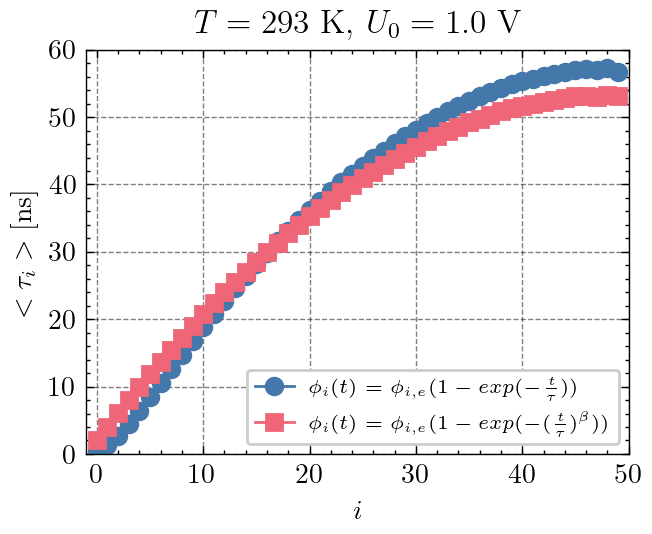

In [10]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
xp  = range(Np)
ax.plot(xp, taus_hot, '-o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(xp, taus_hot_stretched, '-s', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.set_xlabel("$i$")
ax.set_ylabel("$<\\tau_i>$ [ns]")
ax.set_ylim(0,60)
ax.set_xlim(-1,50)
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

# fig.savefig("../plots/dc_input/linear/closed_circuit_node_time_scales.svg", transparent=True)

In [11]:
1/(2*np.pi)

0.15915494309189535

In [137]:
def mode_time_scale_theory(n: int, R: float, Cm: float, Cs: float, N: int)->float:
    a       = R*(Cs+2*Cm*(1-np.cos(n*np.pi/(N+1))))
    b       = 2*(1-np.cos(n*np.pi/(N+1)))
    return a/b

def solve_a_values(U0: float, N: int)->np.ndarray:
    i_vals = np.arange(1, N + 1)
    n_vals = np.arange(1, N + 1)
    S       = np.array([[np.sin(n * np.pi * i / (N + 1)) for n in n_vals] for i in i_vals])
    rhs     = -U0 * (1 - i_vals / (N + 1))
    return np.linalg.solve(S, rhs)


In [28]:
tau_s               = []
tau_s_stretched     = []

for Np in N_vals:
    taus, std   = characteristic_time_saturation(t_vals, pot, Np)
    tau_s.append(np.max(taus))
    # taus        = characteristic_time_stretched_saturation(t_vals, pot, Np)
    # tau_s_stretched.append(np.max(taus))

tau_i_n0    = mode_time_scale_theory(1, R, Cm, Cs, np.array(N_vals))

In [103]:
tau_i   = []

for N in N_vals:
    tau_n   = mode_time_scale_theory(np.arange(1,N+1),R,Cm,Cs,N)
    a_n     = -solve_a_values(U_0, N)
    tau_sum = np.sum(tau_n)
    tau_i.append(tau_sum*1e9)

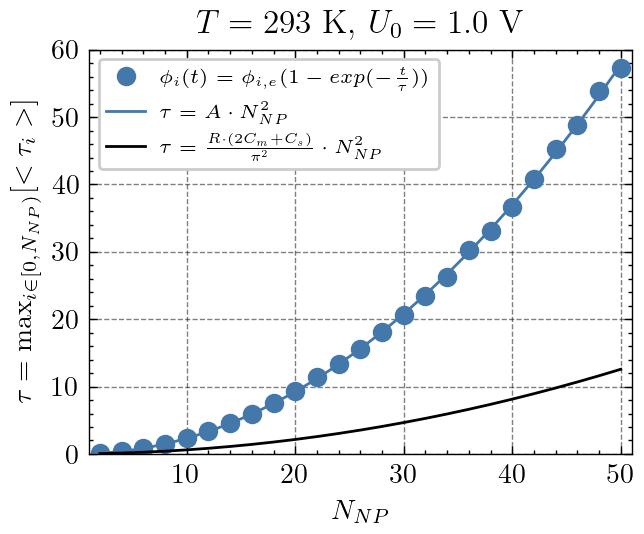

In [65]:
def quad_func(x, a):
    return a*x**2

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

p,_ = curve_fit(quad_func, N_vals, tau_s)
pp  = ax.plot(N_vals, tau_s, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

p,_ = curve_fit(quad_func, N_vals, tau_s_stretched)
pp  = ax.plot(N_vals, tau_s_stretched, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

# ax.plot(N_vals, quad_func(np.array(N_vals), R*(2*Cm+Cs)*1e9 / (np.pi**2)), color='black', label="$\\tau = \\frac{R \cdot (2C_m + C_s)}{\pi^2} \cdot N_{NP}^2$")
ax.plot(N_vals, tau_i, color='black', label="$\\tau = \\frac{R \cdot (2C_m + C_s)}{\pi^2} \cdot N_{NP}^2$")

# ax.set_ylabel("$\\underset{i \in [0,N_{NP})}{\max} <\\tau_i>$")
ax.set_ylabel("$\\tau = \max_{i \in [0,N_{NP})}[<\\tau_i>]$")
ax.set_ylim(0,60)
ax.set_xlim(1,51)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/linear/closed_circuit_time_scales_vs_N.svg", transparent=True)

- $N^2$ dependence as we have **diffusive-limited relaxation** (governed by $R$ and $C$)
- We get about the same prefactor as theory suggests. Deviations due to finite-$N$
- We have a ***hierarchical timescale*** of eigenmodes, i.e. first NPs relax faster and last NP are driven by slowest mode

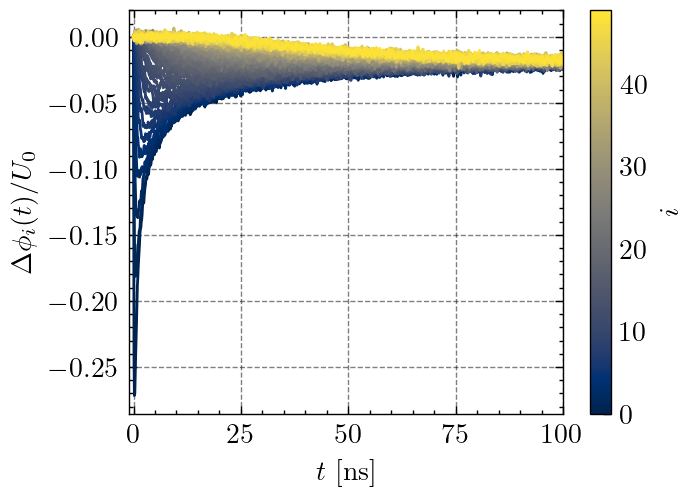

In [105]:
Np      = 50
norm    = Normalize(vmin=0, vmax=(Np-1))
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np-1):
    ax.plot(t_f_d, p_diff[:,i]/U_0, color=cm(norm(i)), label=f'${i}$')
ax.set_xlim(-1,100)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

# ax.legend(fontsize='x-small', ncol=2)

## DC Input - Voltage Distribution - Open Circuit

In [141]:
# folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/293/"
folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/293/"
N_voltages  = 40000
U_0         = 1.0
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
pot         = {N_p : pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_eq      = pd.DataFrame([pot[N_p].iloc[38000:,:].mean().values / U_0 for N_p in N_vals],index=N_vals).T.round(2)

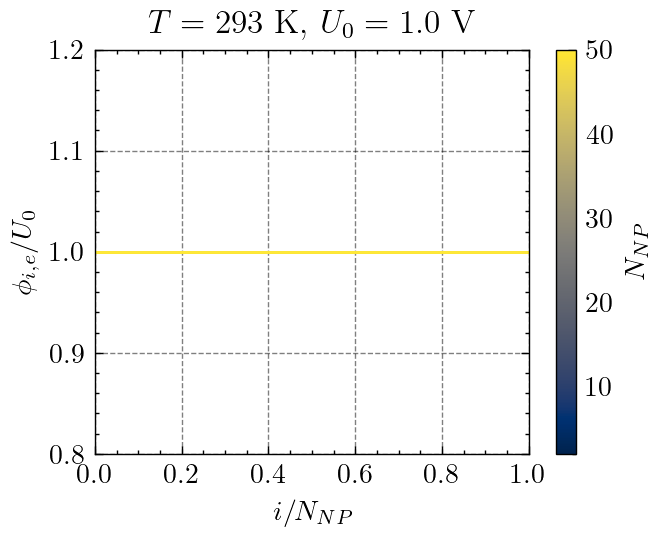

In [142]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    p   = pot_eq[N].dropna().values.copy()
    p   = np.insert(p, 0, 1.0)
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(N)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_ylim(0.8,1.2)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_potential.svg", transparent=True)

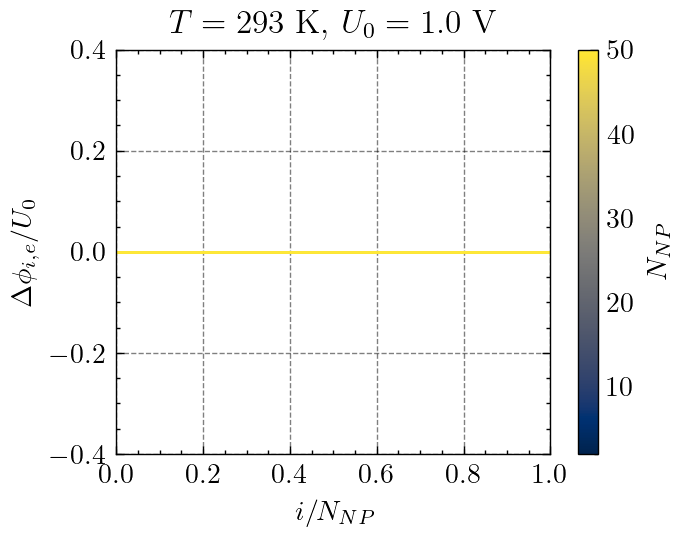

In [143]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    arr = pot_eq[N].dropna().values.copy()*U_0
    arr = np.insert(arr, 0, U_0)
    arr = np.diff(arr)/U_0
    x   = np.linspace(0,1,len(arr))

    ax.plot(x, arr, color=cm(norm(N)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_xlim(0,1)
ax.set_ylim(-0.4, 0.4)
ax.set_ylabel("$\Delta \phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_potential_difference.svg", transparent=True)

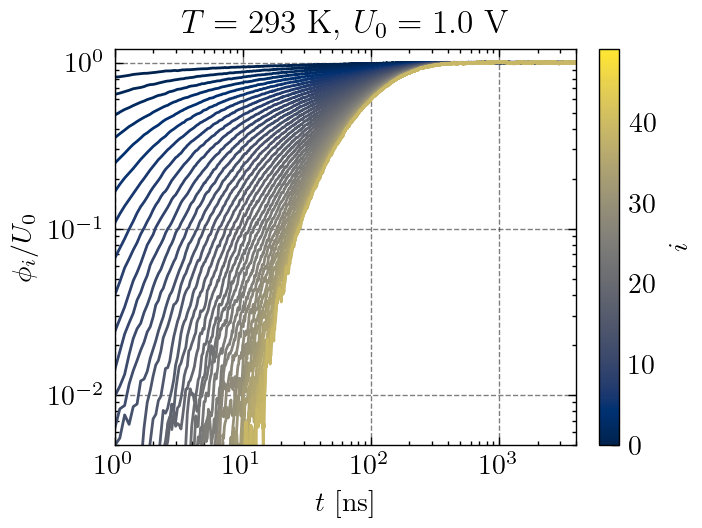

In [144]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
norm    = Normalize(vmin=0, vmax=49)
Np      = 40

for i in range(Np):
    ax.plot(t_vals, pot[Np][f"{i}"].values/U_0, color=cm(norm(i)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_xlim(1,4000)
ax.set_ylim(0.005,1.2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_time_series.svg", transparent=True)

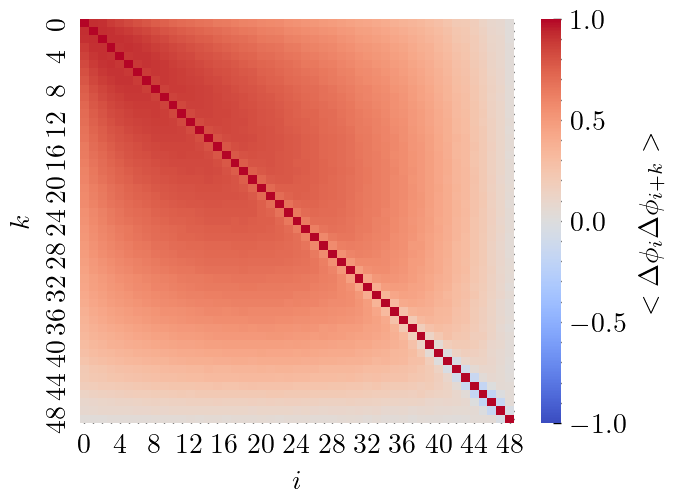

In [145]:
Np      = 50
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax, cbar_kws={"label":"$<\Delta\phi_i\Delta\phi_{i+k}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_pot_diff_corr.svg", transparent=True)

- Without a ground path, charges accumulate until the **entire string floats** at $U_0$ --> $\phi_i \approx U_0 \forall i$

In [146]:
Np                  = 50
taus_hot, std_hot   = characteristic_time_saturation(t_vals, pot, Np)
taus_hot_stretched  = characteristic_time_stretched_saturation(t_vals, pot, Np, p0=[5,1,1])

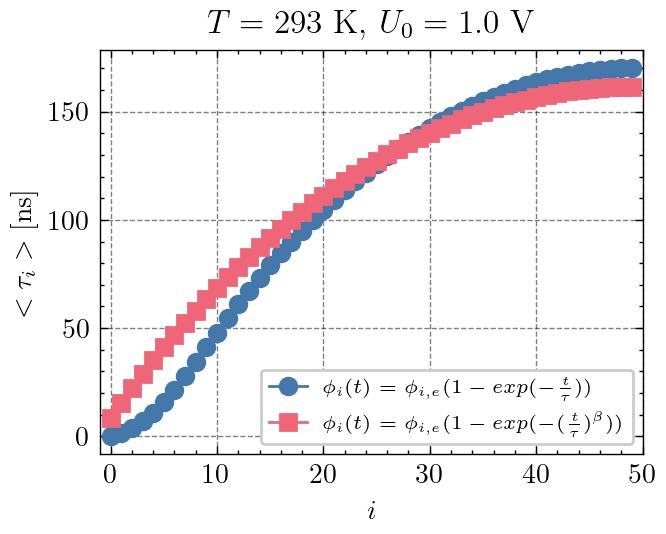

In [147]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
xp  = range(Np)
ax.plot(xp, taus_hot, '-o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(xp, taus_hot_stretched, '-s', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.set_xlabel("$i$")
ax.set_ylabel("$<\\tau_i>$ [ns]")
# ax.set_ylim(0,60)
ax.set_xlim(-1,50)
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/linear/open_circuit_node_time_scales.svg", transparent=True)

In [148]:
np.max(taus_hot_stretched)

np.float64(161.60919639527583)

In [84]:
tau_s               = []
tau_s_stretched     = []

for Np in N_vals:
    taus, std   = characteristic_time_saturation(t_vals, pot, Np)
    tau_s.append(np.max(taus))
    taus        = characteristic_time_stretched_saturation(t_vals, pot, Np)
    tau_s_stretched.append(np.max(taus))

ValueError: `ydata` must not be empty!

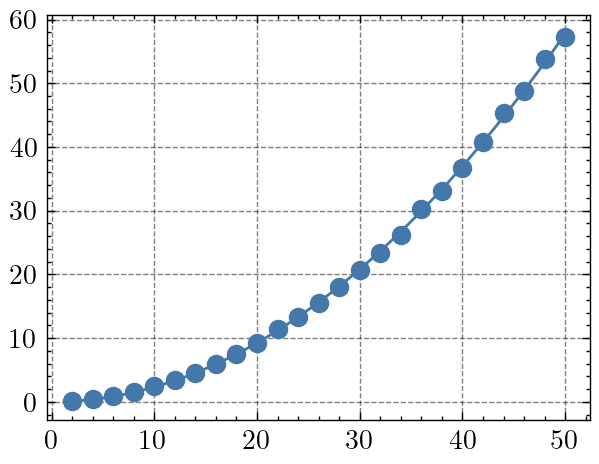

In [123]:
def quad_func(x, a):
    return a*x**2

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

p,_ = curve_fit(quad_func, N_vals, tau_s)
pp  = ax.plot(N_vals, tau_s, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

p,_ = curve_fit(quad_func, N_vals, tau_s_stretched)
pp  = ax.plot(N_vals, tau_s_stretched, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

ax.plot(N_vals, quad_func(np.array(N_vals), R*Cm*1e9), color='black', label="$\\tau = RC \cdot N_{NP}^2$")

# ax.set_ylabel("$\\underset{i \in [0,N_{NP})}{\max} <\\tau_i>$")
ax.set_ylabel("$\\tau = \max_{i \in [0,N_{NP})}[<\\tau_i>]$")
ax.set_ylim(0,200)
ax.set_xlim(1,51)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/linear/open_circuit_time_scales_vs_N.svg", transparent=True)

In [121]:
N   = 50
n   = 7

print(np.cos((2*n-1)*np.pi*N/(2*N)))
print(np.cos((2*n-1)*np.pi*(N+1)/(2*N)))

-9.803364199544708e-16
-0.3971478906347843


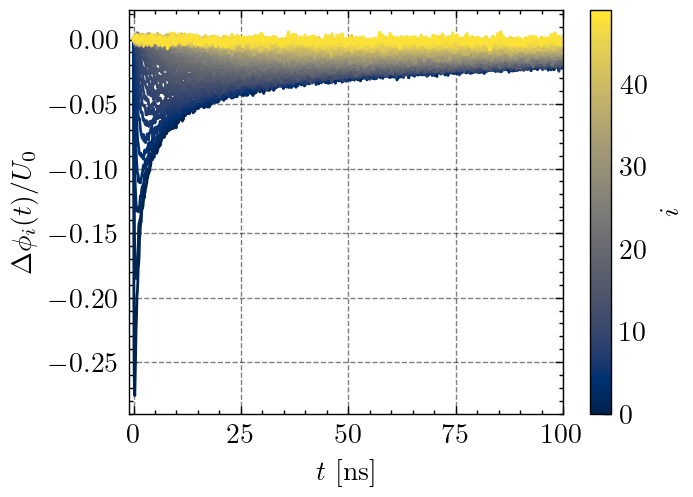

In [78]:
Np      = 50
norm    = Normalize(vmin=0, vmax=(Np-1))
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np-1):
    ax.plot(t_f_d, p_diff[:,i]/U_0, color=cm(norm(i)), label=f'${i}$')
ax.set_xlim(-1,100)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

# ax.legend(fontsize='x-small', ncol=2)

In [101]:
N_periods   = 40
time_step   = 1e-9
f0          = 10*1e6
T0          = 1 / f0
N_samples_p = int(T0 / time_step)
N_voltages  = int(N_periods*N_samples_p)
N_voltages

3960

In [99]:
T0 / time_step

9.999999999999999e-16

---